# Space Titanic

Voor deze opdracht gaan jullie meedoen met een online competitie op Kaggle, namelijk de [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/overview) om te voorspellen wie ontvoerd wordt en wie niet.
Na het aanvaarden van de regels van de competitie is het mogelijk om met je Kaggle account de dataset te downloaden.

Deze opdracht bestaat uit twee delen.
Eerst ga je de dataset verkennen en bestuderen welke data beschikbaar en bruikbaar is.
In deze stap ga je ook eventuele problemen in de dataset aanpakken.
In een tweede stap ga je dan een model bouwen om te voorspellen wie gaat ontvoerd worden en wie niet.
De techniek die je hierbij gaat gebruiken wordt bepaald door de groep waarin je zit. 

## Exploratory Data Analysis

Download eerst de datasets in de code cellen hieronder en lees de train.csv file in met pandas.
Beantwoord de volgende vragen:
* Hoeveel null-waarden zijn er aanwezig in welke kolom?
* Hoeveel unieke waarden bevatten de HomePlanet en Destination kolommen. Zou je deze waarden encoderen via one-hot encoding of ordinal encoding? Waarom? Doe deze encodering.
* Cast het datatype van boolean kolommen naar integerkolommen zodat de waarden 0 en 1 zijn. Voeg ook code toe om de correcte werking te controleren.
* Zijn er kolommen waarvan de data niet bruikbaar is/zou zijn om de waarde in de Transported kolom te voorspellen? Wat is je reden om voor deze kolommen te kiezen? Laat deze kolommen vallen.
* De cabin kolom heeft nog een niet-numerieke waarde die we nog niet bekeken hebben. Splits deze waarde in drie op basis van de "/". Bewaar elke waarde in een aparte kolom en voeg ordinal encoding uit op de niet-numerieke kolommen. Zorg ervoor dat de kolommen van de Cabin kolom respectievelijk de naam "Deck", "Room" en "Side" krijgen. Dit is een unieke beschrijving voor de locatie van de kamer op het schip.
* Welke feature heeft de sterkste correlatie met de target waarde (Transported)? Is dit een positieve of negatieve correlatie. Wat houdt dit in?
* Bekijk de pairplot van de verschillende features t.o.v. het label/target. Zijn deze verbanden lineair of van hogere orde?

**Antwoorden:**
* Vraag 1: PassengerId: 0, HomePlanet: 201, CryoSleep: 217, Cabin: 199, Destination: 182, Age 179, VIP: 203, RoomService: 181, FoodCourt: 183, ShoppingMall: 208, Spa: 183, VRDeck: 188, Name: 200, Transported: 0.
* Vraag 2: HomePlanet: 3, Destination: 3. We zouden gebruik maken van one hot encoding. Het is categorieke data. Aantal kolommen is nog niet te groot dus dat zal voor geen problemen zorgen.
* Vraag 3: Eerst alle NaNs opgevuld door meest voorkomende waarde in die kolom op hele dataframe. Dan true/false (bool) omgezet naar ints. Dan controle dat er geen bool datatype kolommen overblijven en dat is zo dus ok.
* Vraag 4: Volgens ons zijn de naam en passengerid overbodig. Ze veranderen praktisch voor elke rij, ze zijn meer een identifier van de rij dan echt een eigenschap waar men op kan trainen.
* Vraag 5: In orde.
* Vraag 6: CryoSleep heeft de sterkste correlatie met Transported. Het is een positieve correlatie. Dit houdt in dat CryoSleep en Transported de sterkste (positieve) samenhang hebben, ze beinvloeden elkaar het hardst.
* Vraag 7: Er zijn zo goed als geen verbanden. De meeste grafieken zijn stip grafieken.

In [32]:
# imports
import opendatasets as od
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import tree
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

#download
od.download("https://www.kaggle.com/competitions/spaceship-titanic/data")

Skipping, found downloaded files in ".\spaceship-titanic" (use force=True to force download)


In [33]:
# data cleaning
train = pd.read_csv('.\\spaceship-titanic\\train.csv')
test = pd.read_csv('.\\spaceship-titanic\\test.csv')

# vraag 1:
print('Aantal NaNs per kolom:')
display(train.isnull().sum())

# vraag 2:
print('Aantal unieke waarden per kolom:')
display(train.nunique())

train_onehotencoded = pd.get_dummies(train, columns = ['HomePlanet', 'Destination'])
test_onehotencoded = pd.get_dummies(test, columns = ['HomePlanet', 'Destination'])

# vraag 3:
# alle NaNs opvullen met meest voorkomende value in die kolom (zoals desicion trees eigenlijk zelf doet, maar omdat we eerst nog bools naar ints omvormen doen we het zelf eerst):
train_onehotencoded_fixnan = train_onehotencoded.fillna(train_onehotencoded.mode().iloc[0])
test_onehotencoded_fixnan = test_onehotencoded.fillna(test_onehotencoded.mode().iloc[0])

# alle kolommen met true/false omvormen naar ints
train_onehotencoded_fixnan['CryoSleep'] = train_onehotencoded_fixnan['CryoSleep'].astype(int)
train_onehotencoded_fixnan['VIP'] = train_onehotencoded_fixnan['VIP'].astype(int)
train_onehotencoded_fixnan['Transported'] = train_onehotencoded_fixnan['Transported'].astype(int)
test_onehotencoded_fixnan['CryoSleep'] = test_onehotencoded_fixnan['CryoSleep'].astype(int)
test_onehotencoded_fixnan['VIP'] = test_onehotencoded_fixnan['VIP'].astype(int)

print('HomePlanet en Destinatino one hot encoded:')
display(train_onehotencoded_fixnan)

print('Controle nog kolommen met datatype boolean over:')
# check of er nog bool kolommen zijn (antw = nee dus in orde)
display(train_onehotencoded_fixnan.select_dtypes(include='bool'))

# vraag 4:
train = train_onehotencoded_fixnan
test = test_onehotencoded_fixnan
train.drop(columns=['Name'], inplace=True)
test.drop(columns=['Name'], inplace=True)

print('Train tabel na Name kolom te droppen:')
display(train)

# vraag 5:
train_gesplit = train['Cabin'].str.split(pat = '/', expand = True)
test_gesplit = test['Cabin'].str.split(pat = '/', expand = True)
train_gesplit.rename(columns={0: 'Deck', 1: 'Room', 2: 'Side'}, inplace=True)
test_gesplit.rename(columns={0: 'Deck', 1: 'Room', 2: 'Side'}, inplace=True)

print('Cabin splitsen:')
display(train_gesplit)

encoder = OrdinalEncoder()
train_gesplit[['Deck', 'Side']] = encoder.fit_transform(train_gesplit[['Deck', 'Side']].values).astype('int')
test_gesplit[['Deck', 'Side']] = encoder.fit_transform(test_gesplit[['Deck', 'Side']].values).astype('int')

print('Cabin gesplits one hot encoding en terug samengevoegd:')
train = pd.merge(train, train_gesplit, left_index=True, right_index=True)
test = pd.merge(test, test_gesplit, left_index=True, right_index=True)
train.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)
train['Room'] = train['Room'].astype(int)
test['Room'] = test['Room'].astype(int)

train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

display(train)
display(test)

Aantal NaNs per kolom:


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Aantal unieke waarden per kolom:


PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

HomePlanet en Destinatino one hot encoded:


,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,B/0/P,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,0,0,1
1,0002_01,0,F/0/S,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0,0,0,0,1
2,0003_01,0,A/0/S,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,0,0,0,1
3,0003_02,0,A/0/S,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,0,0,0,1
4,0004_01,0,F/1/S,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,A/98/P,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,1,0,1,0,0
8689,9278_01,1,G/1499/S,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,1,0,0,0,1,0
8690,9279_01,0,G/1500/S,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,1,0,0,0,0,1
8691,9280_01,0,E/608/S,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,0,1,0,1,0,0


Controle nog kolommen met datatype boolean over:


""
0
1
2
3
4
...
8688
8689
8690
8691


Train tabel na Name kolom te droppen:


,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,B/0/P,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1
1,0002_01,0,F/0/S,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,0,0,0,1
2,0003_01,0,A/0/S,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,0,0,1
3,0003_02,0,A/0/S,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,0,0,1
4,0004_01,0,F/1/S,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,A/98/P,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,1,0,1,0,0
8689,9278_01,1,G/1499/S,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0
8690,9279_01,0,G/1500/S,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,0,0,0,0,1
8691,9280_01,0,E/608/S,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,0,1,0,1,0,0


Cabin splitsen:


,Deck,Room,Side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


Cabin gesplits one hot encoding en terug samengevoegd:


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck,Room,Side
PassengerId,,,,,,,,,,,,,,,,,,
0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,1,0,0
0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,0,0,0,1,5,0,1
0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,0,0,1,0,0,1
0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,0,0,1,0,0,1
0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,0,0,0,0,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,1,0,1,0,0,0,98,0
9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,6,1499,1
9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,0,0,0,0,1,6,1500,1


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck,Room,Side
PassengerId,,,,,,,,,,,,,,,,,
0013_01,1,27.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,6,3,1
0018_01,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,0,0,0,0,1,5,4,1
0019_01,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,2,0,1
0021_01,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0,1,0,0,0,1,2,1,1
0023_01,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,0,0,0,0,1,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,1,34.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,6,1496,1
9269_01,0,42.0,0,0.0,847.0,17.0,10.0,144.0,1,0,0,0,0,1,6,160,0
9271_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,3,296,0


Text(0.5, 1.0, 'Correlation Matrix Train data')

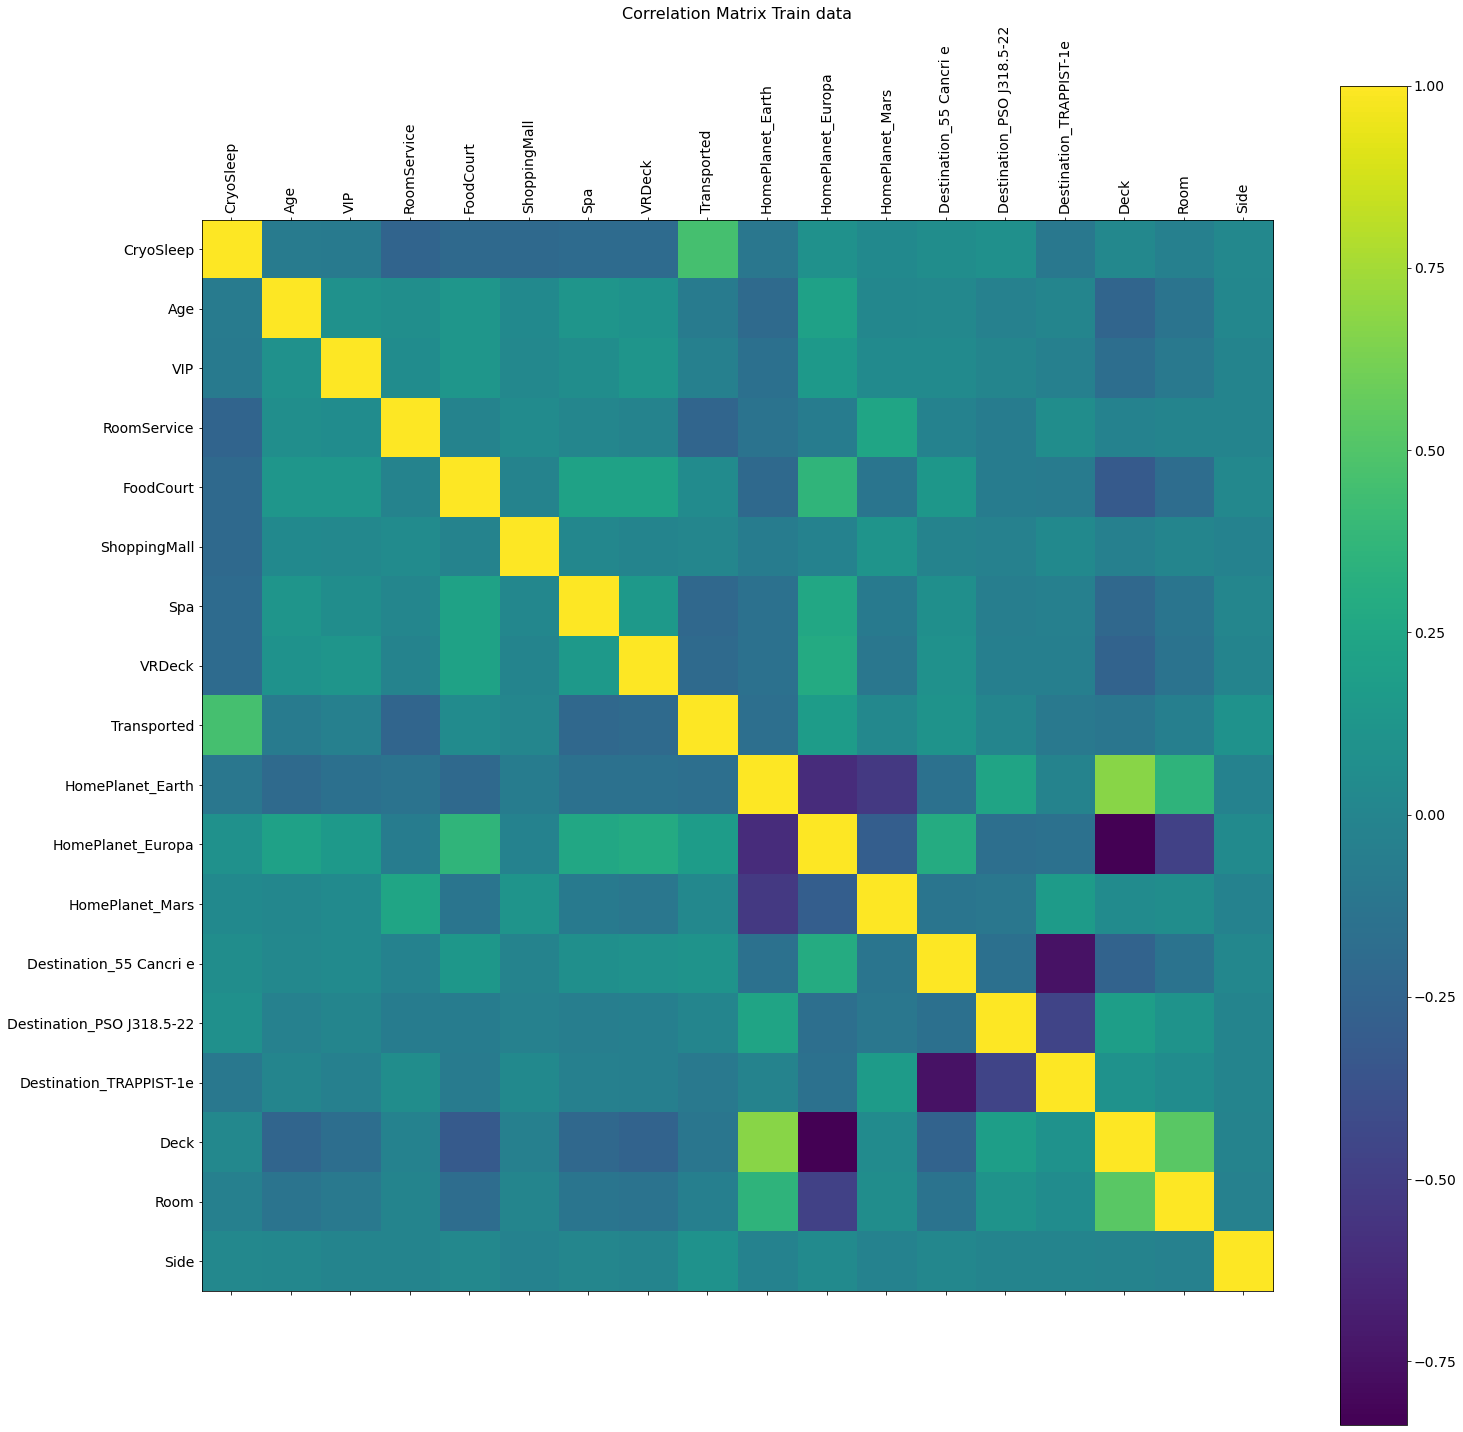

In [34]:
# correlation
f = plt.figure(figsize=(24,24))
plt.matshow(train.corr(), fignum=f.number)
plt.xticks(range(len(train.columns)), train.columns, rotation=90, fontsize=14)
plt.yticks(range(len(train.columns)), train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation Matrix Train data", fontsize=16)

# CryoSleep heeft de hoogste correlatie met transported.

# de matrix printen om te controleren welk nu echt de hoogste correlatie heeft (meer zekerheid als visueel)
# matrix = train.corr()
# print(matrix)

In [35]:
# pair plot
sns.pairplot(train)

## Modelling

Bestudeer eerst de techniek die aan je groep is toegewezen.

**Maak een presentatie waarin je de volgende vragen beantwoord:**
* Hoe werkt de techniek?
* Over welke hyperparameters beschikt de techniek? Wat stellen die voor? Wat zijn vaak gebruikte waarden?
* In welke situaties werkt de techniek goed en in welke werkt het minder goed?
* Hoe kan je overfitting tegengaan met deze techniek.
* Hoe gebruik je de techniek? Train hiervoor minstens 2 modellen per teamlid met verschillende en bespreek de impact van de gewijzigde hyperparameters. Toon en leg uit tijdens je presentatie de code van 1 model.
* Bespreek de behaalde resultaten op basis van verscheidene metrieken zoals accuraatheid, f1-score en training/predict tijd. Is er overfitting/underfitting?
* Bereken de voorspelling op basis van de testdata. Sla deze resultaten op in een csv en dien het in op Kaggle. Op welke plaats eindig je?

Deze presentatie moet een 25-30 minuten duren en wordt gepresenteerd tijdens de eerste week van het tweede kwartaal.

In [ ]:
# data modelling

# Model 1 (Quinten Stroobants)
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_split = 4)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_entropy_maxdepth8_minsamplessplit4.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [ ]:
fig = plt.figure(figsize=(250,75))
treeplot = tree.plot_tree(clf, fontsize = 12, filled = True,feature_names = test.columns, rounded = True)

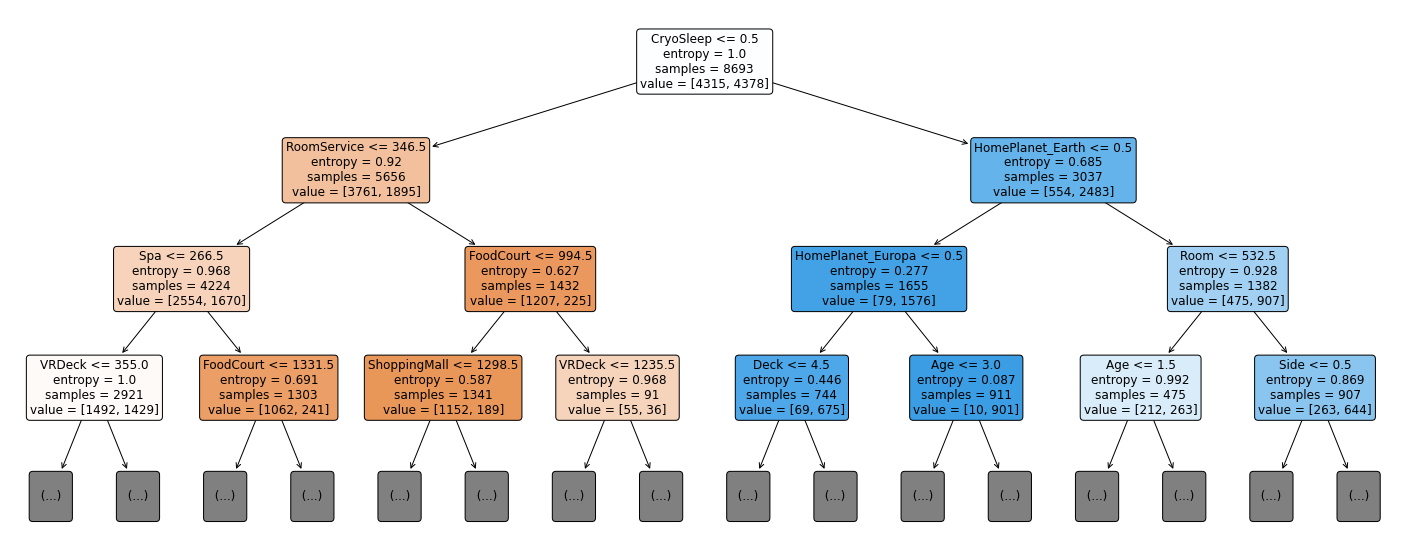

In [ ]:
fig = plt.figure(figsize=(25,10))
treeplottopview = tree.plot_tree(clf, fontsize = 12, filled = True,feature_names = test.columns, rounded = True, max_depth = 3)

In [ ]:
# Model 1 (Mike Moonens)
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_split = 2)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_entropy_maxdepth5_minsamplessplit2.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,False


In [ ]:
# Model 2 (Mike Moonens)
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_split = 2)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_entropy_maxdepth6_minsamplessplit2.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,True
4274,9271_01,True
4275,9273_01,False


In [ ]:
# Model 1 (Lorenzo Danau)

clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, min_samples_split = 3)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_gini_maxdepth6_minsamplessplit3.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,True
4274,9271_01,True
4275,9273_01,False


In [ ]:
# Model 2 (Lorenzo Danau)
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, min_samples_split = 2)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_entropy_maxdepth9_minsamplessplit2.csv', index=False)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
# Model 1 (Rob de Rop)
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_split = 2)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_gini_maxdepth8_minsamplessplit2.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [ ]:
# Model 2 (Rob de Rop)
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_split = 2, splitter = 'random')
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_entropy_maxdepth7_minsamplessplit2_random.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [ ]:
# Model 1 (Kevin Leroy)
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_split = 3, splitter = 'random')
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_gini_maxdepth5_minsamplessplit3_random.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
# Model 2 (Kevin Leroy)
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_split = 2)
traindatazondertransport = train.loc[:, train.columns != 'Transported']

clf = clf.fit(X = traindatazondertransport, y = train['Transported'])
prediction = clf.predict(test)

output = test.copy().reset_index()[['PassengerId']]
output['Transported'] = prediction.tolist()
output['Transported'] = output['Transported'].astype('bool')

display(output)
output.to_csv('sample_submission_gini_maxdepth10_minsamplessplit2.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


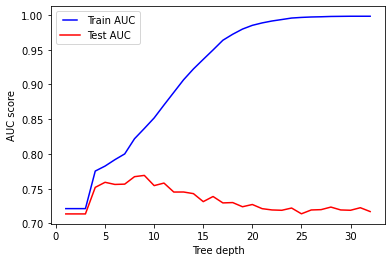

In [ ]:
# analyse en splitsen

# Bron: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
train = pd.read_csv('.\\spaceship-titanic\\train.csv')
train_onehotencoded = pd.get_dummies(train, columns = ['HomePlanet', 'Destination'])
train_onehotencoded_fixnan = train_onehotencoded.fillna(train_onehotencoded.mode().iloc[0])
train_onehotencoded_fixnan['CryoSleep'] = train_onehotencoded_fixnan['CryoSleep'].astype(int)
train_onehotencoded_fixnan['VIP'] = train_onehotencoded_fixnan['VIP'].astype(int)
train_onehotencoded_fixnan['Transported'] = train_onehotencoded_fixnan['Transported'].astype(int)
train = train_onehotencoded_fixnan
train.drop(columns=['Name'], inplace=True)
train_gesplit = train['Cabin'].str.split(pat = '/', expand = True)
train_gesplit.rename(columns={0: 'Deck', 1: 'Room', 2: 'Side'}, inplace=True)
encoder = OrdinalEncoder()
train_gesplit[['Deck', 'Side']] = encoder.fit_transform(train_gesplit[['Deck', 'Side']].values).astype('int')
train = pd.merge(train, train_gesplit, left_index=True, right_index=True)
train.drop(columns=['Cabin'], inplace=True)
train['Room'] = train['Room'].astype(int)
train.set_index('PassengerId', inplace=True)

import numpy as np

traincopy = train.copy();
X = traincopy.loc[:, traincopy.columns != 'Transported']
y = traincopy['Transported']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

# Conclusie: er is sprake van overfitting. Dit kan je dus tegen gaan door de tree depth best in te stellen rond 6 a 7

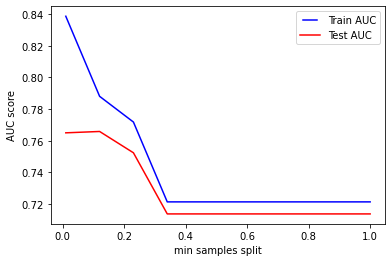

In [ ]:
min_samples_splits = np.linspace(0.01, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

# Conclusie: best zo laag mogelijk aka default.

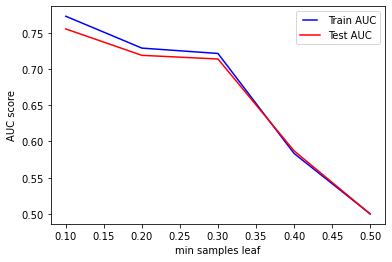

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

# Conclusie: best zo laag mogelijk aka default.

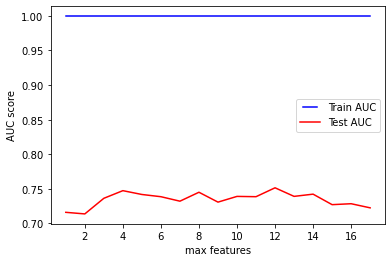

In [ ]:
max_features = list(range(1,train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

# Conclusie: kan geen conclusie trekken. Hoogste UAC waarde van test verandert te veel bij reruns. Soms 2, soms 13, enz... Dus we laten het op default.

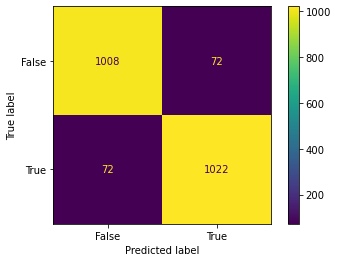

{'Accuracy': 0.9337626494940202, 'Precision': 0.9341864716636198, 'Sensitivity_recall': 0.9341864716636198, 'Specificity': 0.9333333333333333, 'F1_score': 0.9341864716636198}


In [ ]:
# confusion matrix

# eerst train data opsplitsen in train en test
traincopy = train.copy();
X = traincopy.loc[:, traincopy.columns != 'Transported']
y = traincopy['Transported']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# zelfde hyperparameters genomen als waar we op kaggle het meeste haalde
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_split = 4)
clf.fit(x_train, y_train)

y_pred = dt.predict(x_test)

# bron: https://www.w3schools.com/python/python_ml_confusion_matrix.asp

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Sensitivity_recall = metrics.recall_score(y_test, y_pred)
Sensitivity_recall = metrics.recall_score(y_test, y_pred)
Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
F1_score = metrics.f1_score(y_test, y_pred)

print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})